In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from transformers import BertModel, BertTokenizerFast, AdamW
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Preprocessing

In [2]:
# Read the dataset
train_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding="ISO-8859-1")
train_df = train_df.loc[:, ['text', 'sentiment']]
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [3]:
# Read the test dataset
test_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv', encoding="ISO-8859-1")
test_df = test_df.loc[:, ['text', 'sentiment']]
test_df.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [4]:
# Unique classes
train_df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [ ]:
# Check the shape of datasets
train_df.shape, test_df.shape

((27481, 2), (4815, 2))

In [6]:
# Check for missing values
train_df['text'].isna().sum(), test_df['text'].isna().sum()

(1, 1281)

In [7]:
# Remove missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [8]:
# Encode the labels
label_encoding = {'neutral': 0, 'negative': 1, 'positive': 2}
train_df.loc[:, 'label'] = train_df.loc[:, 'sentiment'].map(label_encoding)
test_df.loc[:, 'label'] = test_df.loc[:, 'sentiment'].map(label_encoding)

In [9]:
# Split the DataFrame (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print(len(train_df), len(val_df))

21984 5496


In [10]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_df['text'].tolist(),
    padding='longest',
    max_length=25,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_df['text'].tolist(),
    padding='longest',
    max_length=25,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_df['text'].tolist(),
    padding='longest',
    max_length=25,
    truncation=True
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
# Convert the lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_df['label'].tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_df['label'].tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_df['label'].tolist())

In [13]:
# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Model building

In [14]:
# import BERT-base pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
class BERTModel(nn.Module):
    def __init__(self, bert):
        super(BERTModel, self).__init__()
        for layer in list(bert.children())[:-1]:
            for parameter in layer.parameters():
                parameter.requires_grad = False
        bert.pooler.dense = nn.Linear(in_features=768, out_features=len(label_encoding), bias=True)
        self.bert = bert
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, sent_id, mask):
        out = self.bert(sent_id, attention_mask=mask)
        x = self.softmax(out.pooler_output)
        return x

model = BERTModel(bert)
model = model.to(device)

In [17]:
# Compute the class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=train_y.unique().numpy(), 
    y=train_y.numpy()
)

print("Class Weights:", class_weights)

Class Weights: [0.8251323  1.18022226 1.06295329]


In [18]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights) 

# define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-4)
# number of training epochs
epochs = 25

## Training

In [19]:
def train():
    model.train()
    total_loss = 0
    total_preds = []

    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        # Push batch to GPU
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Clear previously calculated gradients
        model.zero_grad()

        # Get model predictions for the current batch
        preds = model(sent_id, mask)

        # Compute the loss
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Move predictions to CPU and store them
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

        # Update tqdm progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

    # Compute the average loss
    avg_loss = total_loss / len(train_dataloader)

    # Reshape predictions (no. of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [20]:
def evaluate():
    # Deactivate dropout layers
    model.eval()
    
    total_loss = 0
    total_preds = []

    # Wrap val_dataloader with tqdm for progress tracking
    progress_bar = tqdm(val_dataloader, desc="Evaluating", leave=True)

    for batch in progress_bar:
        # Push batch to GPU
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # Deactivate autograd
        with torch.no_grad():
            # Get model predictions
            preds = model(sent_id, mask)

            # Compute validation loss
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            # Move predictions to CPU and store them
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

            # Update tqdm progress bar with loss
            progress_bar.set_postfix(loss=loss.item())

    # Compute the average validation loss
    avg_loss = total_loss / len(val_dataloader)

    # Reshape predictions (no. of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [21]:
# Set initial best validation loss to infinite
best_valid_loss = float('inf')

# Lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# Training loop with tqdm progress bar
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Train model with progress tracking
    train_loss, _ = train()

    # Evaluate model with progress tracking
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/kaggle/working/bert_model.pth')

    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Display epoch summary with tqdm-style formatting
    print(f"Training Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f}")



Epoch 1/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.95it/s, loss=0.924]


Training Loss: 0.931 | Validation Loss: 0.862

Epoch 2/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.95it/s, loss=0.919]


Training Loss: 0.858 | Validation Loss: 0.837

Epoch 3/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.87it/s, loss=0.874]


Training Loss: 0.845 | Validation Loss: 0.817

Epoch 4/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.40it/s, loss=0.848]


Training Loss: 0.835 | Validation Loss: 0.811

Epoch 5/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.40it/s, loss=0.863]


Training Loss: 0.828 | Validation Loss: 0.804

Epoch 6/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.66it/s, loss=0.878]


Training Loss: 0.825 | Validation Loss: 0.801

Epoch 7/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.61it/s, loss=0.922]


Training Loss: 0.821 | Validation Loss: 0.804

Epoch 8/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.58it/s, loss=0.873]


Training Loss: 0.818 | Validation Loss: 0.796

Epoch 9/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.70it/s, loss=0.906]


Training Loss: 0.817 | Validation Loss: 0.798

Epoch 10/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.63it/s, loss=0.919]


Training Loss: 0.812 | Validation Loss: 0.796

Epoch 11/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.74it/s, loss=0.913]


Training Loss: 0.811 | Validation Loss: 0.797

Epoch 12/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.71it/s, loss=0.898]


Training Loss: 0.812 | Validation Loss: 0.791

Epoch 13/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.71it/s, loss=0.907]


Training Loss: 0.812 | Validation Loss: 0.793

Epoch 14/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.54it/s, loss=0.873]


Training Loss: 0.810 | Validation Loss: 0.788

Epoch 15/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.77it/s, loss=0.886]


Training Loss: 0.809 | Validation Loss: 0.786

Epoch 16/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.71it/s, loss=0.879]


Training Loss: 0.808 | Validation Loss: 0.791

Epoch 17/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.66it/s, loss=0.916]


Training Loss: 0.807 | Validation Loss: 0.790

Epoch 18/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.48it/s, loss=0.937]


Training Loss: 0.803 | Validation Loss: 0.791

Epoch 19/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.66it/s, loss=0.914]


Training Loss: 0.807 | Validation Loss: 0.787

Epoch 20/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.39it/s, loss=0.926]


Training Loss: 0.805 | Validation Loss: 0.786

Epoch 21/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.38it/s, loss=0.909]


Training Loss: 0.803 | Validation Loss: 0.785

Epoch 22/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.71it/s, loss=0.914]


Training Loss: 0.803 | Validation Loss: 0.785

Epoch 23/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.64it/s, loss=0.928]


Training Loss: 0.803 | Validation Loss: 0.785

Epoch 24/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.72it/s, loss=0.918]


Training Loss: 0.806 | Validation Loss: 0.784

Epoch 25/25


Evaluating: 100%|██████████| 172/172 [00:04<00:00, 35.72it/s, loss=0.914]

Training Loss: 0.805 | Validation Loss: 0.787


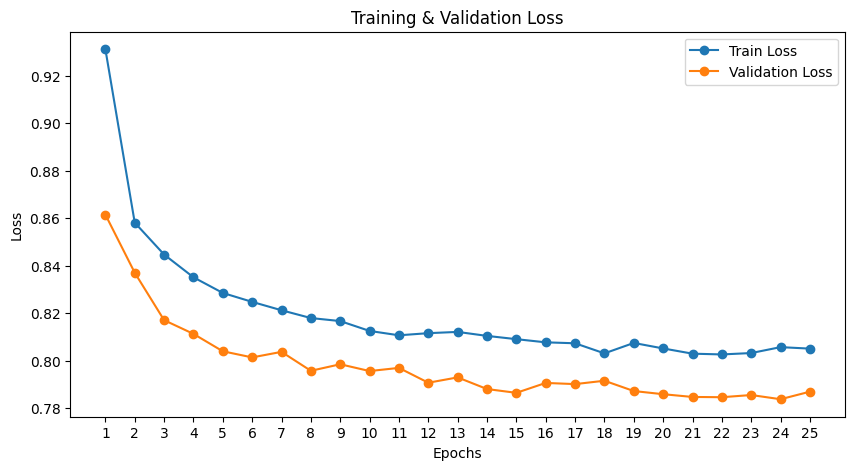

In [22]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss', marker='o')
plt.xticks(range(1, epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [23]:
#load weights of best model
path = '/kaggle/working/bert_model.pth'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.70      0.49      0.58      1430
           1       0.60      0.76      0.67      1001
           2       0.65      0.75      0.70      1103

    accuracy                           0.65      3534
   macro avg       0.65      0.67      0.65      3534
weighted avg       0.66      0.65      0.64      3534

